## Imports

In [1]:
from pathlib import Path
import json
from collections import defaultdict

In [2]:
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytesseract as tess
from PIL import Image
from sklearn.cluster import DBSCAN

## Loading Data

In [17]:
# data_dir = Path(r"C:\datasets\pubtabnet")
data_dir = Path(r"C:\Users\stans\Documents\Projects\Datasets\pubtabnet.tar\pubtabnet\pubtabnet")
test_dir = data_dir / "train"

In [18]:
files = list(test_dir.glob("*.png"))

In [5]:
# with open(data_dir / "PubTabNet_2.0.0.jsonl", "r", encoding="utf8") as f:
#     json_list = list(f)

In [6]:
# fname_index_map = {}

# for i, json_str in enumerate(json_list):
#     result = json.loads(json_str)
#     fname_index_map[result["filename"]] = i

## Data Utils
Utility functions for interacting with the PubTabNet Dataset

In [7]:
def Y(i):
    fname = files[i]
    i = fname_index_map[fname.parts[-1]]
    return json.loads(json_list[i])

def X(i):
    return Image.open(files[i])

## Image Utils

In [8]:
def scale(im, scale):
    return im.resize((int(x*scale) for x in im.size))


COLORS = {
    'black':(0,0,0),
    'red':(150,0,0),
    'green':(0,150,0),
    'blue':(0,0,150)
}

def draw(im, bbox, color='black'):
    im = np.array(im)  # in case it is in PIL format
    x,y,w,h = bbox
    W,H,_ = im.shape
    
    if isinstance(color, str):
        color = COLORS[color]
    
    pt1 = (x, y)
    pt2 = (x+w, y+h)
    return cv2.rectangle(im, pt1=pt1, pt2=pt2,
        color=color, thickness=1
    )

## Tesseract Utils

In [9]:
def tessdata_to_df(tessdata, keep_garbage=False):
    """Ingests a string repr of tesseract output and spits out a dataframe"""
    rows = [r.split("\t") for r in tessdata.split("\n")[:-1]]
    h = rows[0]
    rows = rows[1:]
        
    df = pd.DataFrame(rows)
    df.columns = h
    
    # set types
    dtypes = [int]*10 + [float, str]
    for c,t in zip(df.columns, dtypes):
        df[c] = df[c].values.astype(t)
    
    if not keep_garbage:
        df = df[[x.strip() != "" for x in df["text"]]]
        df = df[df["conf"] > 0].reset_index()
    
    return df


def fit_bboxes_to_text(im, tessdata):
    """
    Tesseract bboxes sometimes have very wide margins on them. This is bad for the purpose
    of determining the grid that defines the layout.
    Shrinks each side of the bbox until ~8% of the darkness is lost.
    
    im <PIL.Image or np.array()>: image used for cropping out the boxes defined in tessdata
    
    tessdata <Pandas.DataFrame>: Should be a dataframe with columns ["left","top","width","height"]
        as is returned by tessdata_to_df
    """
    df_left = tessdata["left"].values
    df_top = tessdata["top"].values
    df_width = tessdata["width"].values
    df_height = tessdata["height"].values
    
    im = np.array(im).sum(axis=2)
    im = im / im.max()
    im = abs(im - 1)
    for i, bbox in enumerate(tessdata[['left', 'top', 'width', 'height']].values):
        x,y,w,h = bbox
        cropped = im[y:y+h, x:x+w]
        
        v_sum = cropped.sum(axis=1)
        h_sum = cropped.sum(axis=0)
        
        top = 0
        while sum(v_sum[top:]) > sum(v_sum)*0.98 and top < len(v_sum)-3:
            top += 1
            
        bottom = len(v_sum)
        while sum(v_sum[top:bottom]) > sum(v_sum)*0.96 and bottom > top+2:
            bottom -= 1
            
            
        left = 0
        while sum(h_sum[left:]) > sum(h_sum)*0.98 and left < len(h_sum)-3:
            left += 1
            
        right = len(h_sum)
        while sum(h_sum[left:right]) > sum(h_sum)*0.96 and right > left+2:
            right -= 1
        
        df_left[i] = x + left
        df_top[i] = y + top
        df_width[i] = right-left
        df_height[i] = bottom-top
        
    df = tessdata.copy()
    df["left"] = df_left
    df["top"] = df_top
    df["width"] = df_width
    df["height"] = df_height
    return df


def im_to_data(im):
    tessdata = tess.image_to_data(im, config="--psm 1")
    return tessdata_to_df(tessdata)

## Grid Detection

### OCR Method
Tesseract's `image_to_data` function returns all detected words and their bounding boxes.<br>
The following process determines if two tokens are part of the same cell based entirely on proximity.<br> 
After which, the bbox of each cell can be determined and finally the table grid
can be fit to the cell boundaries.

### Color Method
This method assumes that darker pixels correspond to text within a cell. The mask<br>
used to generate the cell grid is just the normalized black/white image. This method is<br>
faster but more noisy than the ocr method.

### Combine Tokens into Cells (ocr method)

In [10]:
def group_tokens(df, im=None, direction="Both", v=0):
    """
    """
    im_cp = im
    assert isinstance(direction, str)
    scale_y = 2
    median_font_height = df["height"].median()
    eps_multiplier = 1
    
    model = DBSCAN(
        eps=median_font_height * eps_multiplier,  # TODO: gridsearch the multiple for this
        min_samples=2  # used to connect two tokens into the same cell
    )
    
    # if v > 1:   
    #     # draw a green box around detected token groups
    #     for i, bbox in enumerate(df[['left', 'top', 'width', 'height']].values):
    #         x,y,w,h = bbox
    #         im = draw(im, bbox, 'blue')
    
    points = []
    tokens = []
    for i, bbox in enumerate(df[['left', 'top', 'width', 'height']].values):
        x,y,w,h = bbox
        
        y = y*scale_y
        tokens += [i]*8  # the next 8 points correspond to token[i]
        
        points.append([x, y+h/2])  # veritcally centered, left
        points.append([x+w, y+h/2])  # vertically centerd, right
        points.append([x+w/2, y])  # horizontally centered, top
        points.append([x+w/2, y+h])  # horizontally centerd, bottom
        points.append([x, y])  # top left
        points.append([x, y+h])  # bottom left
        points.append([x+w, y])  # top right
        points.append([x+w, y+h])  # bottom right
        
    if v > 1:
        assert im is not None
        
        # draw a red dot to show the points of each token
        im = np.array(im)  # ensure cv2 format
        for p in points:
            x,y = int(p[0]), int(p[1]/scale_y)
            im[y-2:y+2,x-2:x+2] = [255,0,0]
    
    groups = model.fit_predict(points)
    
    if v > 1:
        # draw a blue line between connected dots
        for i in range(max(groups)+1):
            last = None
            for j in [x for x in range(len(groups)) if groups[x] == i]:
                if last:
                    p1 = int(points[last][0]), int(points[last][1]/scale_y)
                    p2 = int(points[j][0]), int(points[j][1]/scale_y)
                    im = cv2.line(
                        im,
                        p1,
                        p2,
                        color=(0,0,255),
                        thickness=2,
                    )
                last = j
    
    # shrink df to predicted cells
    #
    # I conceptualize this as connecting constructing multiple chains
    # one link at a time in no particular order.
    # The DBSCAN model told us which links are connected, now we need
    # to construct all of the chains.
    
    # initialize the chain datastructure with all chains length 1
    # corresponding to the tokens in the original dataframe
    token_groups = defaultdict(list)
    for i in range(len(df)):
        token_groups[i].append(i)
    
    ## connecting the links
    ### iterate through the detected groups and connect chains together
    ### TODO: Something in here is broken, some words get duplicated a bunch
    for i in range(max(groups)+1):
        idxs = list(set([tokens[x] for x in range(len(groups)) if groups[x] == i]))
        root = idxs[0]
        
        visited = set()
        if isinstance(token_groups[root], int):
            root = token_groups[root]
            
        assert isinstance(token_groups[root], list)
        
        for j in idxs[1:]:
            children = token_groups[j]
            if isinstance(children, int):
                children = token_groups[children]
            
            assert isinstance(children, list)
            root_children = token_groups[root] + children
            for c in children:
                token_groups[c] = root
            token_groups[root] = root_children
            
            
    rows = []
    for key, val in list(token_groups.items()):
        if isinstance(val,list):
            t_pos = list(zip(df["text"][val], df["left"][val], df["top"][val]))
            
            # sort tokens by y (at resolution of font height), break ties by x (at same res)
            t_pos.sort(
                key = lambda x: (
                    x[2] // median_font_height,
                    x[1] // median_font_height
                )
            )
            
            text = " ".join([x[0] for x in t_pos])
            
            left = min(df["left"][val])
            right = max(df["left"][val] + df["width"][val])
            width = right - left
            
            top = min(df["top"][val])
            bottom = max(df["top"][val] + df["height"][val])
            height = bottom - top
            
            rows.append({
                "left": left,
                "top": top,
                "width": width,
                "height": height,
                "text": text,
            })

    df = pd.DataFrame(rows)
    
    if v > 1:   
        # draw a green box around detected token groups
        for i, bbox in enumerate(df[['left', 'top', 'width', 'height']].values):
            x,y,w,h = bbox
            im = draw(im, bbox, 'green')
        
    if v > 1:
        display(Image.fromarray(im))
    
    return df

In [11]:
# im = scale(X(96), 5)
# df = im_to_data(im)
# df = fit_bboxes_to_text(im, df)

In [12]:
# group_tokens(df, im, v=2)

### Detetermine the Grid

In [587]:
def grid_detect(
    im,
    method="color",  # "color" or "ocr"
    margin=0,
    v_thresh=0.05,
    h_thresh=0.05,
    min_v_gap = 10, # pixels
    min_h_gap = 15, # pixels
    v=0,
):
    """
    im <PIL.Image or imarray>: Image of a table
    
    method <str> ("color"): Determines how the mask (for cell content) is constructed. 
        "color": This method assumes that darker pixels correspond to text within a cell. The mask
            used to generate the cell grid is just the normalized black/white image. This method is
            faster but more noisy than the ocr method.
        "ocr": The image is scanned for words using Tesseract. The bounding boxes of each detected
            word are passed through a distance-based combination algorithm which tries to group bboxes
            which correspond to the same cell. The final bboxes for each cell are then used as the mask.
            This primarily has the advantage of taking font-size into account for the purpose of determining
            cell dimensions.
    
    margin <int> (0): Number of pixels to shrink each token bbox for the purpose
        of determining the grid.
        
    v_thresh <float> (0.1): Threshold for considering a row of pixels to be considered
        a vertical boundary in the grid. Higher values mean fewer rows.
        
    h_thresh <float> (0.1): Threshold for considering a column of pixels to be considered
        a horizontal boundary in the grid. Higher values mean fewer columns.
    
    v <int> (0): Verbose, 0-3. Show various stages of progress.
    """
    
    
    if method == "color":
        mask=np.array(im).sum(axis=2).T  # use raw image instead of textboxes
        mask=mask/mask.max()
        mask-=1
        mask = abs(mask)
        mask = (mask>0.1).astype(int)
        
    elif method == "ocr":
        # use Tesseract to find all words
        df = im_to_data(im)
        df = fit_bboxes_to_text(im, df) # try to remove any extraneous whitespace from the bbox
        df = group_tokens(df, im, v=0) # spacially group bboxes into cells using DBSCAN

        # create a word mask from tesseract bboxes
        mask = np.zeros(im.size)
        for bbox in df[['left', 'top', 'width', 'height']].values:
            x,y,w,h = bbox
            mask[x+margin:x+w-margin,y+margin:y+h-margin]=1
    else:
        raise InvalidArgument("'method' must be \"color\" or \"ocr\"")

    v_density = mask.sum(axis=0)/max(mask.sum(axis=0))
    h_density = mask.sum(axis=1)/max(mask.sum(axis=1))
    
    # scale up the density vectors so that the mean is equal to 0.2
    # this makes the thresholds directly related to the average density
    v_density = v_density / (np.mean(v_density)*4)
    h_density = h_density / (np.mean(h_density)*4)
    
    
    # move down the image and record spans which exceed the threshold for being considered a row
    grid_y = []
    to_del = set()
    y=0
    out=True
    for y,val in enumerate(v_density):
        if val>v_thresh and out:
            out=False
            grid_y.append([y])
        if not val > v_thresh and not out:
            grid_y[-1].append(y)
            out = True
        if not out:  # inside of a peak
            if val > 1.5:
                to_del.add(len(grid_y)-1)
    if method == "color":
        # remove spans which exceed the limit of being considered a row.
        # (this is used to filter out horizontal and vertical lines)
        for x in sorted(list(to_del),reverse=True):
            grid_y.pop(x)
    
        # join spans which are too close together
        # (ocr does this in its own way, taking advantage of known character height)
        tmp = [grid_y[0]]
        for gy in grid_y[1:]:
            l = tmp[-1][1]
            r = gy[0]
            if r-l < min_v_gap:
                tmp[-1][1] = gy[1]
            else:
                tmp.append(gy)
        grid_y = tmp
    
    # expand to fill
    grid_y[0][0]=0
    grid_y[-1][1]=im.size[1]-1
    for i in range(len(grid_y)-1):
        x1 = grid_y[i][1] # end of this
        x2 = grid_y[i+1][0] # begining of next
        m = int((x1+x2)/2)
        grid_y[i][1]=m
        grid_y[i+1][0]=m
    
    grid_x = []
    to_del = set()
    x=0
    out=True
    for x,val in enumerate(h_density):
        if val>h_thresh and out:
            out = False
            grid_x.append([x])
        if not val>h_thresh and not out:
            grid_x[-1].append(x)
            out = True
        if not out:  # inside of a peak
            if val > 1.5:
                to_del.add(len(grid_x)-1)
    
    if method == "color":
        # remove spans which exceed the limit of being considered a row.
        # (this is used to filter out horizontal and vertical lines)
        for x in sorted(list(to_del),reverse=True):
            grid_x.pop(x)

        # join spans which are too close together
        # (ocr does this in its own way, taking advantage of known character height)
        tmp = [grid_x[0]]
        for gx in grid_x[1:]:
            b = tmp[-1][1]
            t = gx[0]
            if t-b < min_h_gap:
                tmp[-1][1] = gx[1]
            else:
                tmp.append(gx)
        grid_x = tmp
    
    # expand to fill
    grid_x[0][0]=0
    grid_x[-1][1]=im.size[0]-1
    for i in range(len(grid_x)-1):
        x1 = grid_x[i][1] # end of this
        x2 = grid_x[i+1][0] # begining of next
        m = int((x1+x2)/2)
        grid_x[i][1]=m
        grid_x[i+1][0]=m
        # diff = x2-x1
        # grid_x[i][1]+=int(3*diff/4)
        # grid_x[i+1][0]-=int(diff/4)
    
    grid = []
    for y in grid_y:
        y1,y2 = y
        for x in grid_x:
            x1,x2 = x
            grid.append([x1,y1,x2-x1,y2-y1])
    
    
    if v > 0:
        for bbox in grid:
            im = draw(im, bbox, 'red')
    if v > 1:
        fig, axs = plt.subplots(2,2)
        axs[1,0].imshow(mask.T)
        axs[1,0].xaxis.set_visible(False)
        axs[1,0].yaxis.set_visible(False)
        axs[1,1].plot(v_density, np.arange(mask.shape[1],0,-1))
        # axs[1,1].xaxis.set_visible(False)
        # axs[1,1].yaxis.set_visible(False)
        axs[1,1].set_xlim([0,1])
        axs[0,0].plot(h_density)
        # axs[0,0].xaxis.set_visible(False)
        # axs[0,0].yaxis.set_visible(False)
        axs[0,0].set_ylim([0,1])
        axs[0,1].imshow(im)
        axs[0,1].xaxis.set_visible(False)
        axs[0,1].yaxis.set_visible(False)
        plt.show()
    
    if v > 2:
        plt.imshow(mask.T)
        plt.show()
    if v > 0:
        display(Image.fromarray(im))
        
    if method=="ocr":
        return grid, df
    return grid

## Text to Cell Mapping
We now have an approximate grid layout for our cells. The next step is to place the text obtained vis ocr<br>
into the correct cell. This, again, is entirely distance based.<br>
If the `ocr` method was used, we can just use the text returned from that as we spent a ton of time (computationally speaking)<br>
to carefully combine the words in the right order.

In [557]:
def im_to_cells(
    im, 
    method="color",
    v=0
):
    if method == "color":
        
        df = im_to_data(im)
        grid = grid_detect(
            im, 
            method=method,
            v=v,
            v_thresh=.05,
            h_thresh=.3,
        )
        pass
    if method == "ocr":
        grid, df = grid_detect(
            im, 
            method=method,
            v=v, 
            margin=0,
            v_thresh=.05,
            h_thresh=.3,
        )
    else:
        raise InvalidArgument("'method' must be \"color\" or \"ocr\"")
        
    centers = []
    for bbox in df[['left', 'top', 'width', 'height']].values:
        x,y,w,h = bbox
        centers.append([x+w/2, y+h/2])
    
    
    
    

In [558]:
f_num = 100

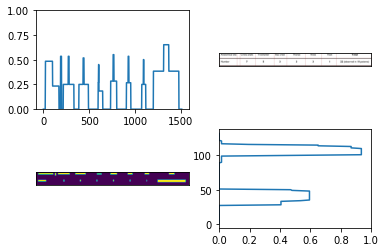

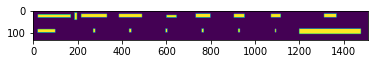

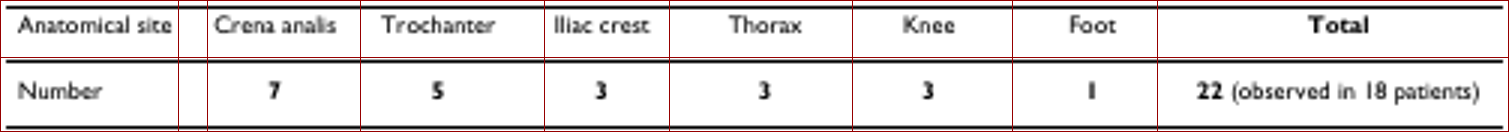

([[0, 0, 178, 57],
  [178, 0, 29, 57],
  [207, 0, 153, 57],
  [360, 0, 184, 57],
  [544, 0, 125, 57],
  [669, 0, 183, 57],
  [852, 0, 160, 57],
  [1012, 0, 145, 57],
  [1157, 0, 351, 57],
  [0, 57, 178, 74],
  [178, 57, 29, 74],
  [207, 57, 153, 74],
  [360, 57, 184, 74],
  [544, 57, 125, 74],
  [669, 57, 183, 74],
  [852, 57, 160, 74],
  [1012, 57, 145, 74],
  [1157, 57, 351, 74]],
     left  top  width  height                          text
 0     22   19    148      14               Anatomical site
 1    187   11     11      32                             =
 2    217   17    116      15                    Crenaanals
 3    387   17    104      15                    Trochanter
 4    601   22     46      11                         crest
 5    733   16     66      17                        Thorax
 6    905   17     48      16                          Knee
 7   1072   17     44      15                          Foot
 8   1311   16     56      16                         Total
 9     21   84

In [569]:
# f_num+=1
grid_detect(
    scale(X(221), 3), 
    method="ocr",
    v=3, 
    margin=0,
    v_thresh=.1,
    h_thresh=.2,
    min_v_gap = 10, # pixels
    min_h_gap = 30, # pixels
)

In [560]:
def contains(coords1, coords2):
    xa, ya, wa, ha = coords1
    xb, yb, wb, hb = coords2
    px = xb + wb/2
    py = yb + hb/2
    return xa < px and (xa + wa) > px and ya < py and (ya + ha) > py


def grid_2_table(grid, df=None):
    cells = [[""] for cell in grid]
    for i,bbox in enumerate(df[['left', 'top', 'width', 'height']].values):
        text = df["text"][i]
        for j, cell in enumerate(grid):
            if contains(cell, bbox):
                cells[j].append(text)
    n = len(set([x[0] for x in grid]))
    cells = [" ".join(x) for x in cells]
    return pd.DataFrame([cells[i:i+n] for i in range(0,len(cells),n)])
    
    

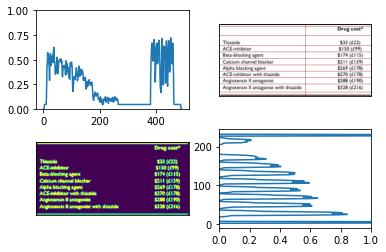

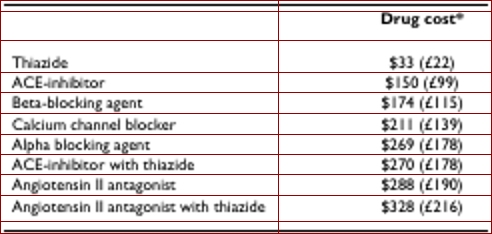

,0,1
0,,
1,,Drug cose™
2,Thiazide,$33 (£22)
3,,$150 (£99)
4,Bera-blocking agent,$174 (£115)
5,Calcium channel blocker,$211 (£13
6,Alpha blocking agent,$269 (£178)
7,ACE.bibitor with thiazide,$270 (£178)
8,Angiotensin Il antagonist,$288 (£190)
9,Angiotensin Il antagonist with thiazide,$328 (£216)


In [633]:
f_num += 1
im = scale(X(f_num), 2)
grid = grid_detect(
    im, 
    method="color",
    margin=0,
    v=2,
    v_thresh=.1,
    h_thresh=.2,
    min_v_gap = 5, # pixels
    min_h_gap = 10, # pixels
)
df = im_to_data(im)
df = grid_2_table(grid, df)
display(df)
# im

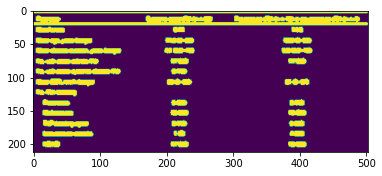

In [195]:
im = np.array(X(50))
blurry_im = cv2.GaussianBlur(im,(5,5),5)
bw = blurry_im.sum(axis=2)
bw = (bw/bw.max()) < .95
plt.imshow(bw)

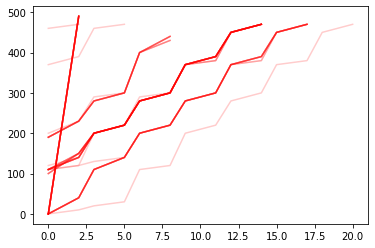

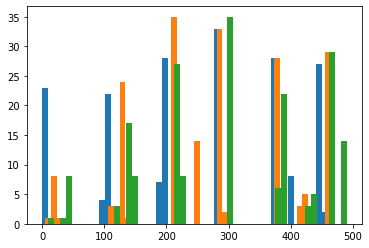

In [335]:
# window params
width = 10
step = 10
thresh = 3
def parameterize(row):
    peaks = [[0,0,0]]
    for i in range(0,len(row)-width+1, step):
        assert len(row[i:i+width]) == width
        if sum(row[i:i+width])>thresh:
            if len(peaks[-1]) == 3:
                peaks.append([i])
        elif len(peaks[-1]) == 1:
            peaks[-1].append((peaks[-1][0]+i)/2)
            peaks[-1].append(i)
    if len(peaks[-1]) == 1:
        peaks[-1].append((peaks[-1][0]+i)/2)
        peaks[-1].append(i)
    # return [sum(x)/2 for x in peaks[1:]]
    return sum(peaks[1:],[])



traces = []
starts = []
stops = []
mids = []
for row in bw:
    t = parameterize(row)
    if sum(t)>0:
        traces.append(t)
        starts += t[0::3]
        mids += t[1::3]
        stops += t[2::3]
        plt.plot(t, color='red', alpha=0.2)
plt.show()
plt.hist(starts, bins = 50)
plt.hist(mids, bins = 50)
plt.hist(stops, bins = 50)
plt.show()

In [336]:
def outliers(x):
    x = np.array(x)
    score = []
    for i in range(len(x)):
        score.append((abs(x-x[i])/len(x)).sum()/500)
    return score

In [337]:
l = max([len(x) for x in traces])
for i in range(len(traces)):
    traces[i] += [0]*(l-len(traces[i]))
    assert len(traces[i]) == l
traces = np.array([np.array(x) for x in traces])

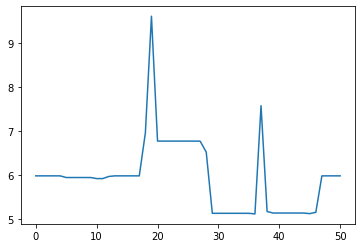

In [338]:
plt.plot(outliers(traces))

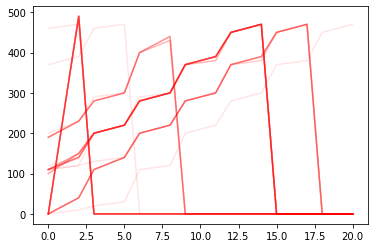

In [339]:
score = outliers(traces)
for t,s in zip(traces, score):
    color = 'blue'
    if s>1.5:
        color = 'red'
    plt.plot(t,color=color,alpha=.1)

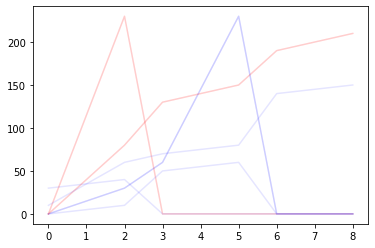

In [390]:
f_num +=1
im = np.array(X(f_num))
blurry_im = cv2.GaussianBlur(im,(5,5),5)
bw = blurry_im.sum(axis=2)
bw = (bw/bw.max()) < .95

traces = []
starts = []
stops = []
for row in bw[::5]:
    t = parameterize(row)
    if sum(t)>0:
        traces.append(t)
l = max([len(x) for x in traces])
for i in range(len(traces)):
    traces[i] += [0]*(l-len(traces[i]))
    assert len(traces[i]) == l
traces = np.array([np.array(x) for x in traces])
score = outliers(traces)
sigma = sum(score)/len(score)

for t,s in zip(traces, score):
    color = 'blue'
    if s>sigma:
        color = 'red'
    plt.plot(t,color=color,alpha=.1)

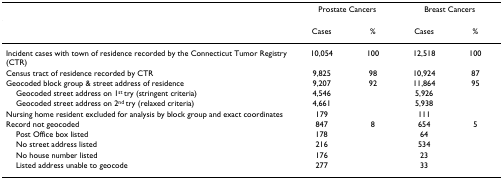

In [383]:
X(f_num)

In [368]:
f_num

222